In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../data/seattle_sample_3k.csv')

In [3]:
data = gpd.GeoDataFrame(data, crs="EPSG:32610", geometry=gpd.points_from_xy(x=data.UTM_X, y=data.UTM_Y))

In [4]:
data = data.to_crs(4326)

In [5]:
data['lon'] = data['geometry'].get_coordinates()['x']

In [6]:
data['lat'] = data['geometry'].get_coordinates()['y']

In [7]:
data['price'] = np.power(10, data['log_price']) / 10000

In [8]:
y = data.price
X = data[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition', 'waterfront', 'view', 'age', 'UTM_X', 'UTM_Y']]
loc = data[['lon', 'lat']]

In [9]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(X, y, loc, train_size=0.8, random_state=42)

In [10]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [11]:
model = xgb.XGBRegressor(n_estimators=500, max_depth=3, min_child_weight=1.0, colsample_bytree=1.0)

In [12]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
explainer = GeoConformalizedExplainer(model, X_train, X_calib, loc_calib.values, loc_test.values, 0.1, 0.15)

In [14]:
results = explainer.uncertainty_aware_explain(x_test=X_test)

Training SHAP


ExactExplainer explainer: 2401it [03:42, 10.45it/s]                          


Calibrating SHAP


ExactExplainer explainer: 301it [01:09,  3.54it/s]                         


Testing SHAP


ExactExplainer explainer: 301it [00:46,  5.48it/s]                         


Explaining Variables


In [15]:
results.accuracy_summary()

,coverage_probability,R2,RMSE,SHAP_Var,Pred_SHAP_Var
bathrooms,0.920000,0.426204,1.460921,3.719601,2.500618
sqft_living,0.926667,0.934237,2.590150,102.015644,130.198834
sqft_lot,0.903333,0.757969,2.417621,24.149358,25.380990
grade,0.943333,0.948129,2.181963,91.784152,118.158733
condition,0.876667,0.890774,0.639536,3.744589,3.705578
waterfront,0.433333,0.708899,2.921203,29.314329,6.680412
view,0.833333,0.870234,1.995822,30.695992,19.323253
age,0.870000,0.565157,2.105581,10.195572,10.425445
UTM_X,0.860000,0.640146,2.511425,17.527276,15.157927
UTM_Y,0.973333,0.967271,2.792078,238.192168,254.387596


In [16]:
results.accuracy_summary().to_csv('./SeattleHomeSale_accuracy_summary.csv')

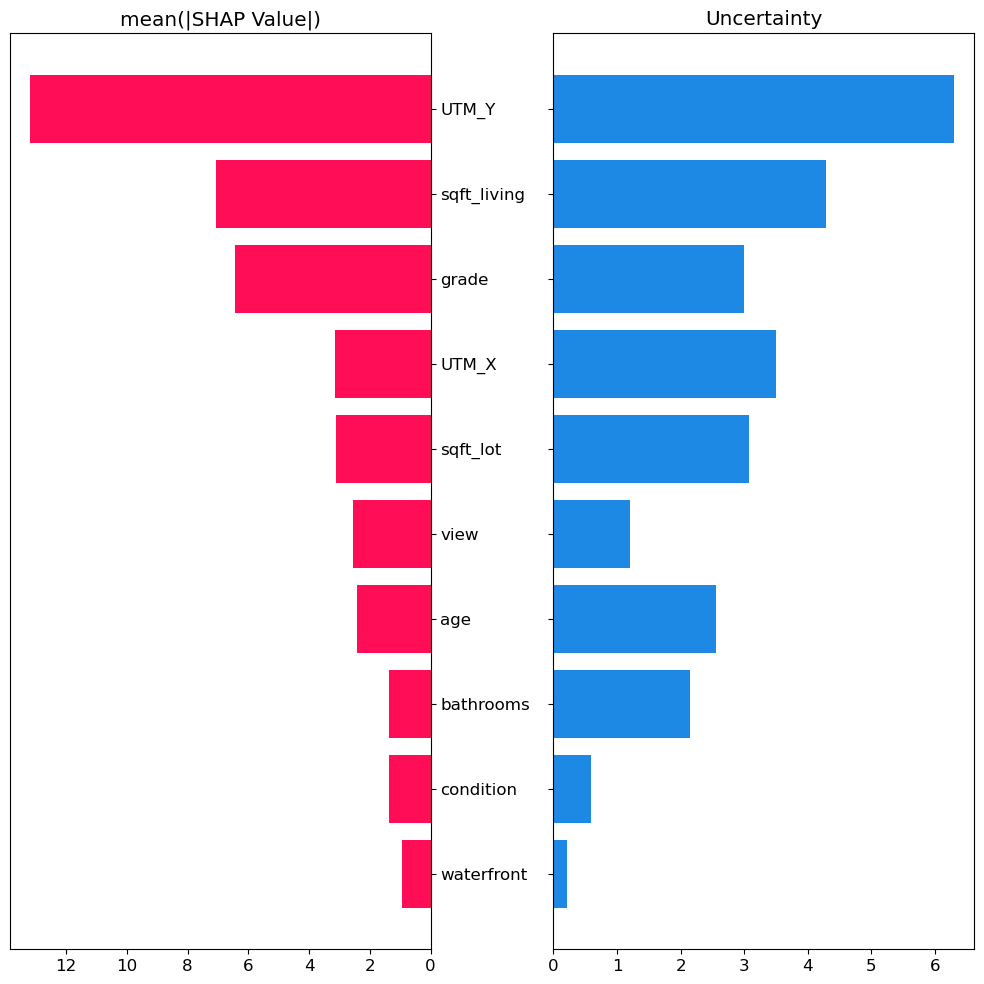

In [17]:
results.plot_absolute_shap_value_with_uncertainty(filename='./SeattleHomeSale_absolute_shap_value_with_uncertainty.pdf')

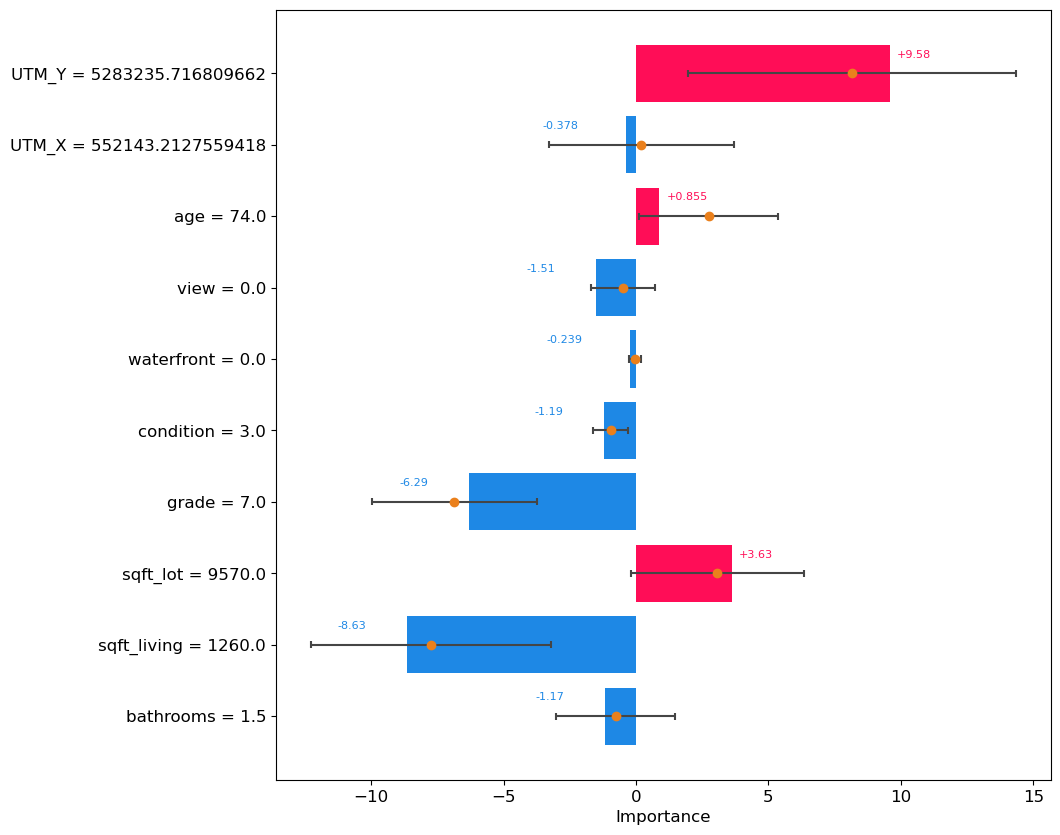

In [18]:
results.plot_shap_values_with_uncertainty(20, filename='./SeattleHomeSale_shap_values_with_uncertainty.pdf')

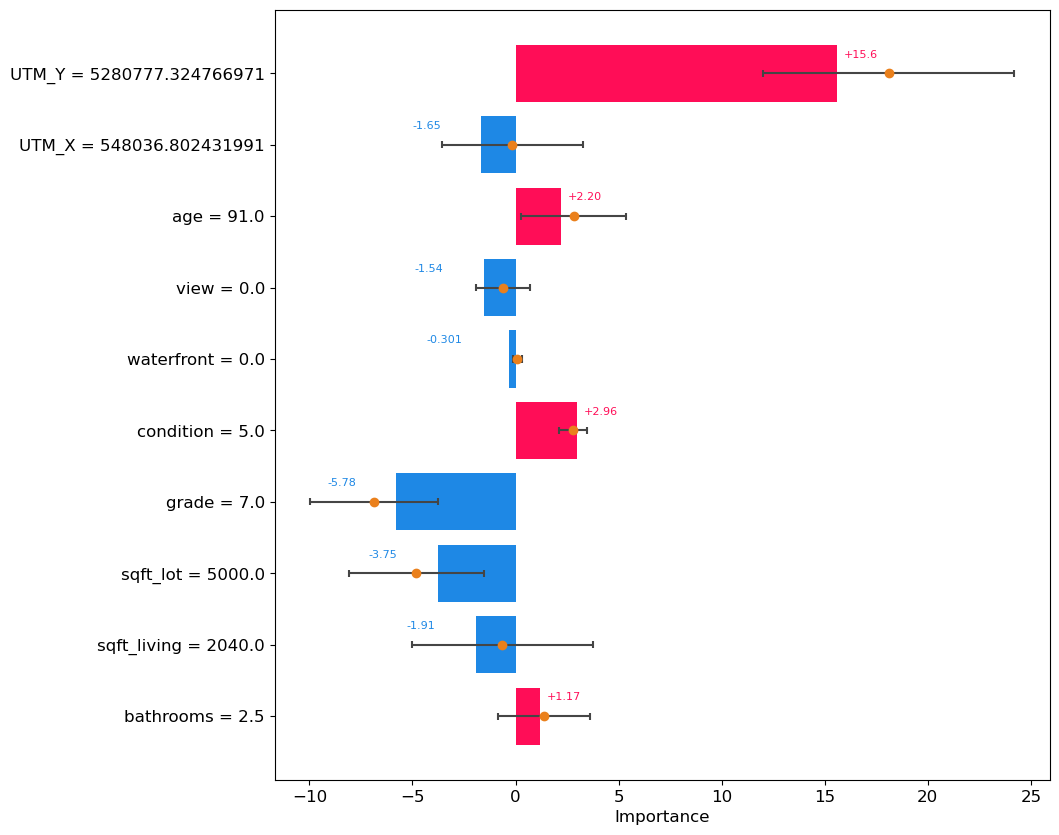

In [19]:
results.plot_shap_values_with_uncertainty(40)

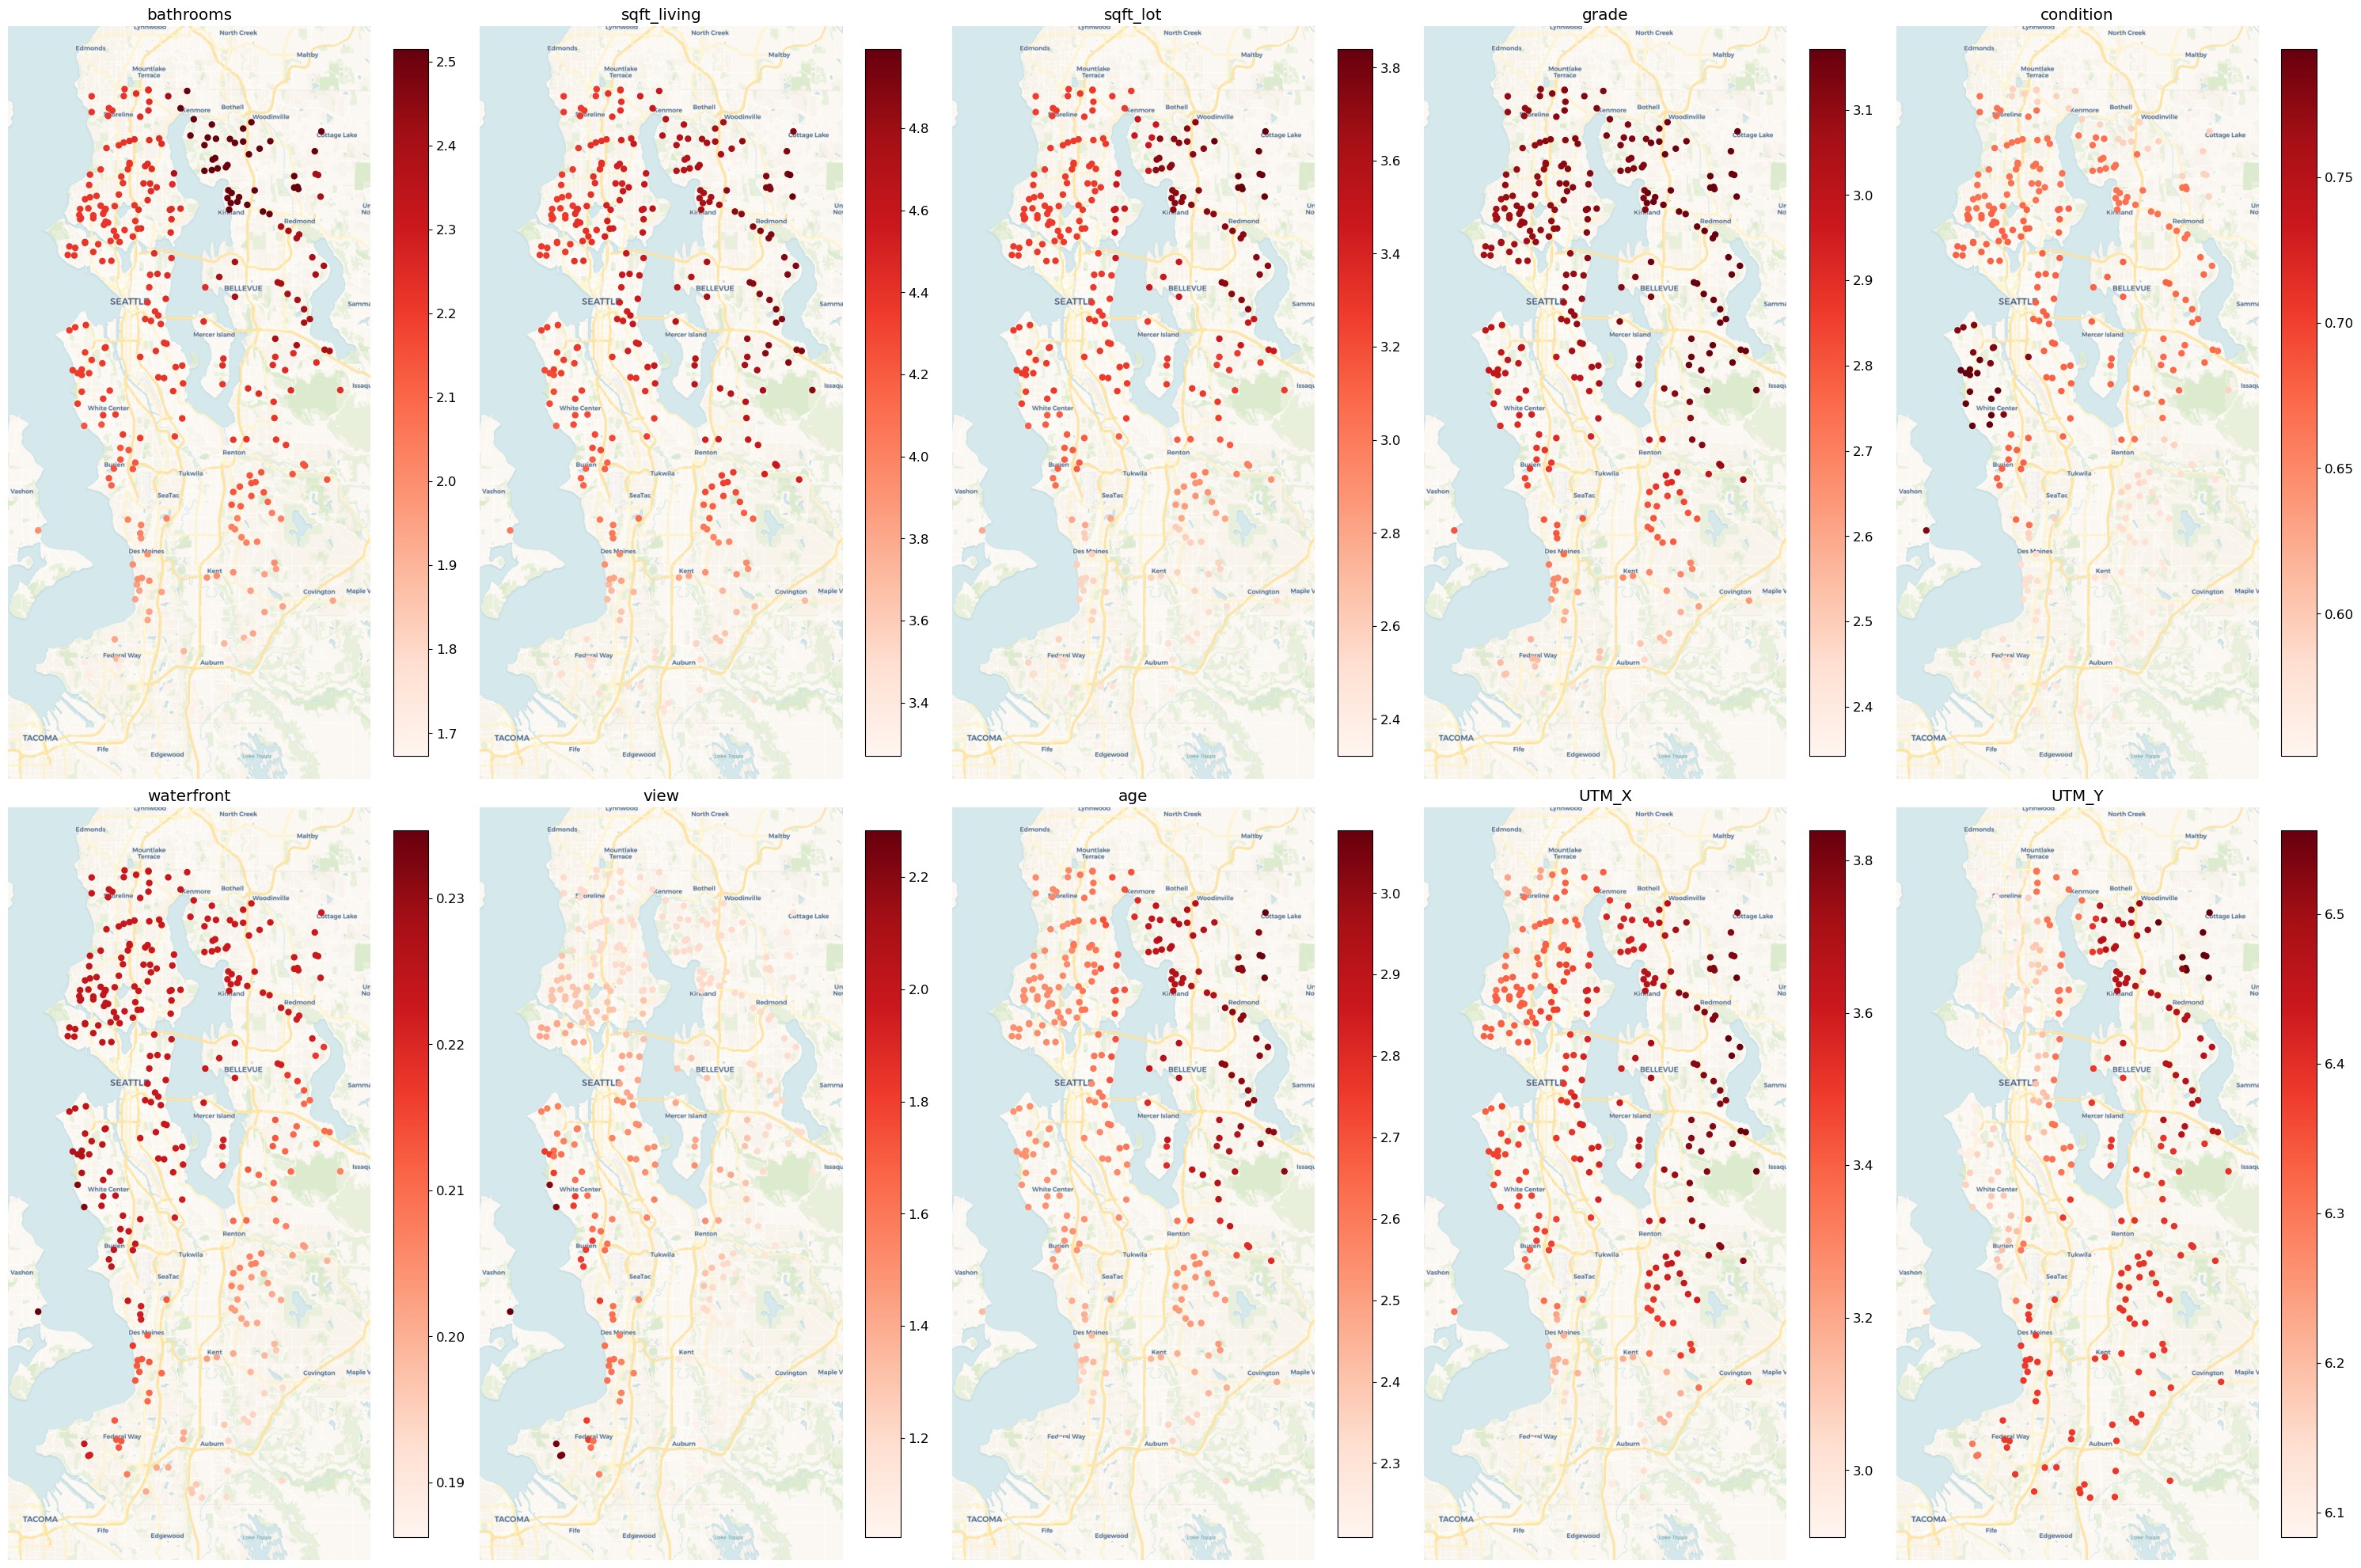

In [20]:
results.plot_geo_uncertainty(figsize=[30, 40], shrink=0.3, filename='./SeattleHomeSale_geo_uncertainty.pdf')

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

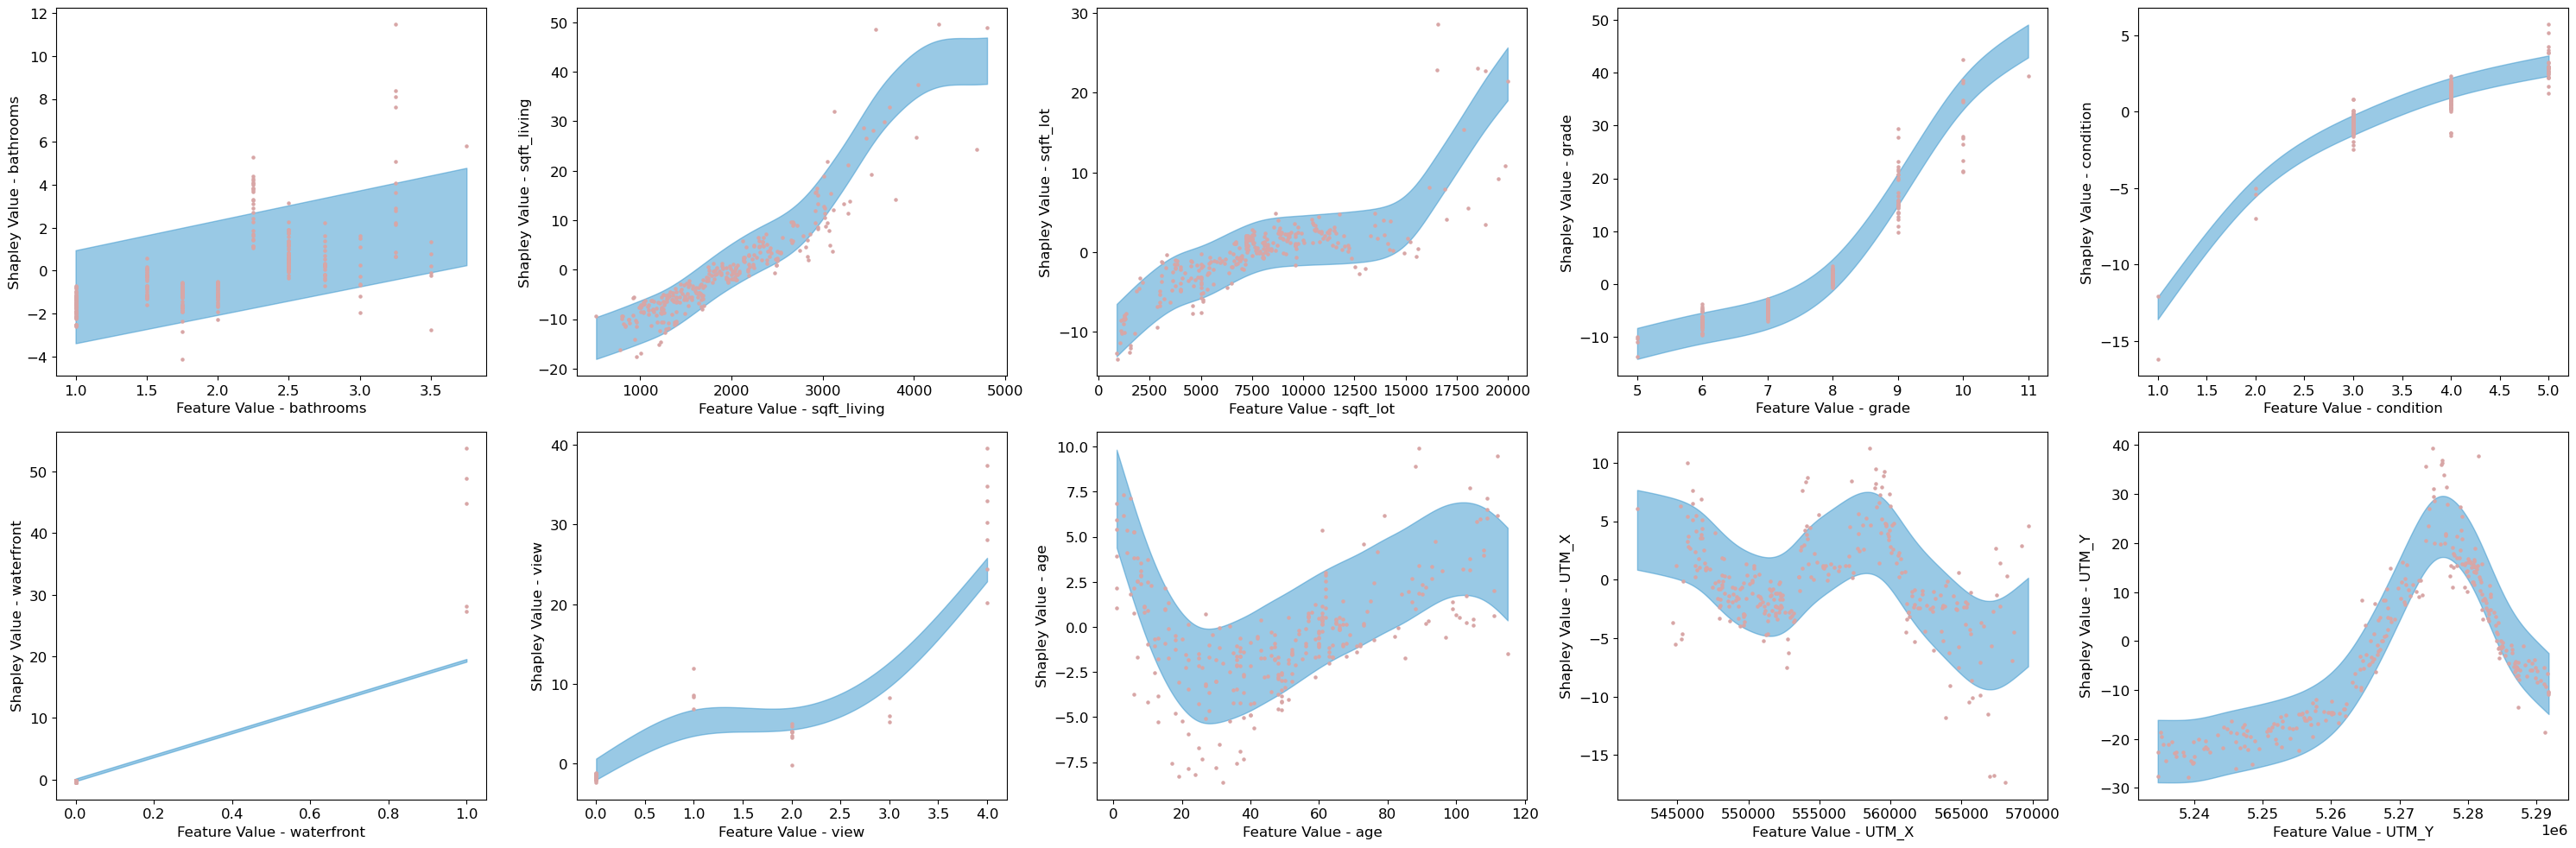

In [21]:
results.plot_partial_dependence_with_fitted_bounds(figsize=[30, 10], filename='SeattleHomeSale_partial_dependence_with_fitted_bounds.pdf')